In [13]:
import os
import xarray as xr
import numpy as np
from statistics import NormalDist
import statsmodels.api as smapi
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
sns.set(style='ticks',font_scale=2)

In [4]:
def ols(x,y,deg=1):
    if np.isnan(x).all() or np.isnan(y).all():
        return np.nan, np.nan

    isna = np.logical_or(np.isnan(x),np.isnan(y))
    x = x[~isna]
    y = y[~isna]
    if (len(x)<20 or len(y)<20):
        return np.nan, np.nan
    if (y==y.max()).all() or (x==x.max()).all():
        return np.nan,np.nan
    mod = smapi.OLS(y,smapi.add_constant(x)).fit()
    return mod.params[1], mod.pvalues[1]


In [5]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'agottlieb','snow_nonlinearity')
data_dir = os.path.join(project_dir,'data','processed')

In [6]:
snotel_ds = xr.open_dataset(os.path.join(data_dir,'snotel','ndjfm_stats.nc'))
ecad_ds = xr.open_dataset(os.path.join(data_dir,'ecad','ndjfm_stats.nc'))
ghcnd_ds = xr.open_dataset(os.path.join(data_dir,'ghcnd','ndjfm_stats.nc'))
insitu_ds = xr.concat([snotel_ds,ecad_ds,ghcnd_ds],dim='site').sel(time=slice("1998","2022"))
insitu_ds = insitu_ds.where(insitu_ds['wy_sc'].median("time")>30,drop=True)
insitu_ds = insitu_ds.where((insitu_ds['wy_sc'].count("time")>=20)&(insitu_ds['tavg'].count("time")>=20),drop=True)
insitu_ds['cold_frac']=1-insitu_ds['warm_days_tavg']/151
insitu_ds['wy_sc'] = insitu_ds['wy_sc'].clip(max=365)
insitu_ds['snow_frac'] = insitu_ds['snow']/(insitu_ds['snow']+insitu_ds['rain'])
insitu_ds['melt_frac'] = 1+insitu_ds['total_melt_prepeak']/insitu_ds['total_accum_prepeak']

In [7]:
insitu_dsc_dt, insitu_dsc_dt_p = xr.apply_ufunc(ols,
                                                insitu_ds['tavg'],
                                                insitu_ds['wy_sc'],
                                                input_core_dims=[['time'],['time']],
                                                output_core_dims=[[],[]],
                                                vectorize=True)
insitu_dsc_dt = 100*insitu_dsc_dt/insitu_ds['wy_sc'].mean("time")
insitu_dsc_dt.name = 'dsc_dt'
insitu_dsc_dt_p.name = 'dsc_dt_p'

In [8]:
insitu_dswe_dt, insitu_dswe_dt_p = xr.apply_ufunc(ols,
                                                insitu_ds['tavg'],
                                                insitu_ds['peak_swe'],
                                                input_core_dims=[['time'],['time']],
                                                output_core_dims=[[],[]],
                                                vectorize=True)
insitu_dswe_dt = 100*insitu_dswe_dt/insitu_ds['peak_swe'].mean("time")
insitu_dswe_dt.name = 'dswe_dt'
insitu_dswe_dt_p.name = 'dswe_dt_p'

In [9]:
insitu_df = xr.merge([insitu_ds[['tavg','tavg_std','cold_frac','snow_frac','melt_frac']].mean("time"),
                      insitu_dsc_dt,insitu_dsc_dt_p,
                      insitu_dswe_dt,insitu_dswe_dt_p]).to_dataframe().dropna()

In [16]:
def corr(x,y):
    isna = np.logical_or(np.isnan(x),np.isnan(y))
    x = x[~isna]
    y = y[~isna]
    if len(x)==0:
        return np.nan
    else:
        return pearsonr(x,y)[0]
sc_swe_corr = xr.apply_ufunc(corr,
                             insitu_ds['peak_swe'],
                             insitu_ds['wy_sc'],
                             input_core_dims=[['time'],['time']],
                             vectorize=True)
sc_swe_corr.name = 'r'

In [11]:
mus = np.arange(-40,11)
sigmas = np.arange(1,13)
cd = pd.DataFrame(index=sigmas,columns=mus)
for m in mus:
    for s in sigmas:
        cd.at[s,m] = NormalDist(m,s).cdf(0)

/scratch/f004260/ipykernel_2321068/582924113.py:52: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cs = ax.contour(cd.astype(float),levels=np.linspace(0.1,1,10),extent=[-40,10,1,12],colors='black',linestyle='--')
/scratch/f004260/ipykernel_2321068/582924113.py:52: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cs = ax.contour(cd.astype(float),levels=np.linspace(0.1,1,10),extent=[-40,10,1,12],colors='black',linestyle='--')
/scratch/f004260/ipykernel_2321068/582924113.py:52: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cs = ax.contour(cd.astype(float),levels=np.linspace(0.1,1,10),extent=[-40,10,1,12],colors='black',linestyle='--')


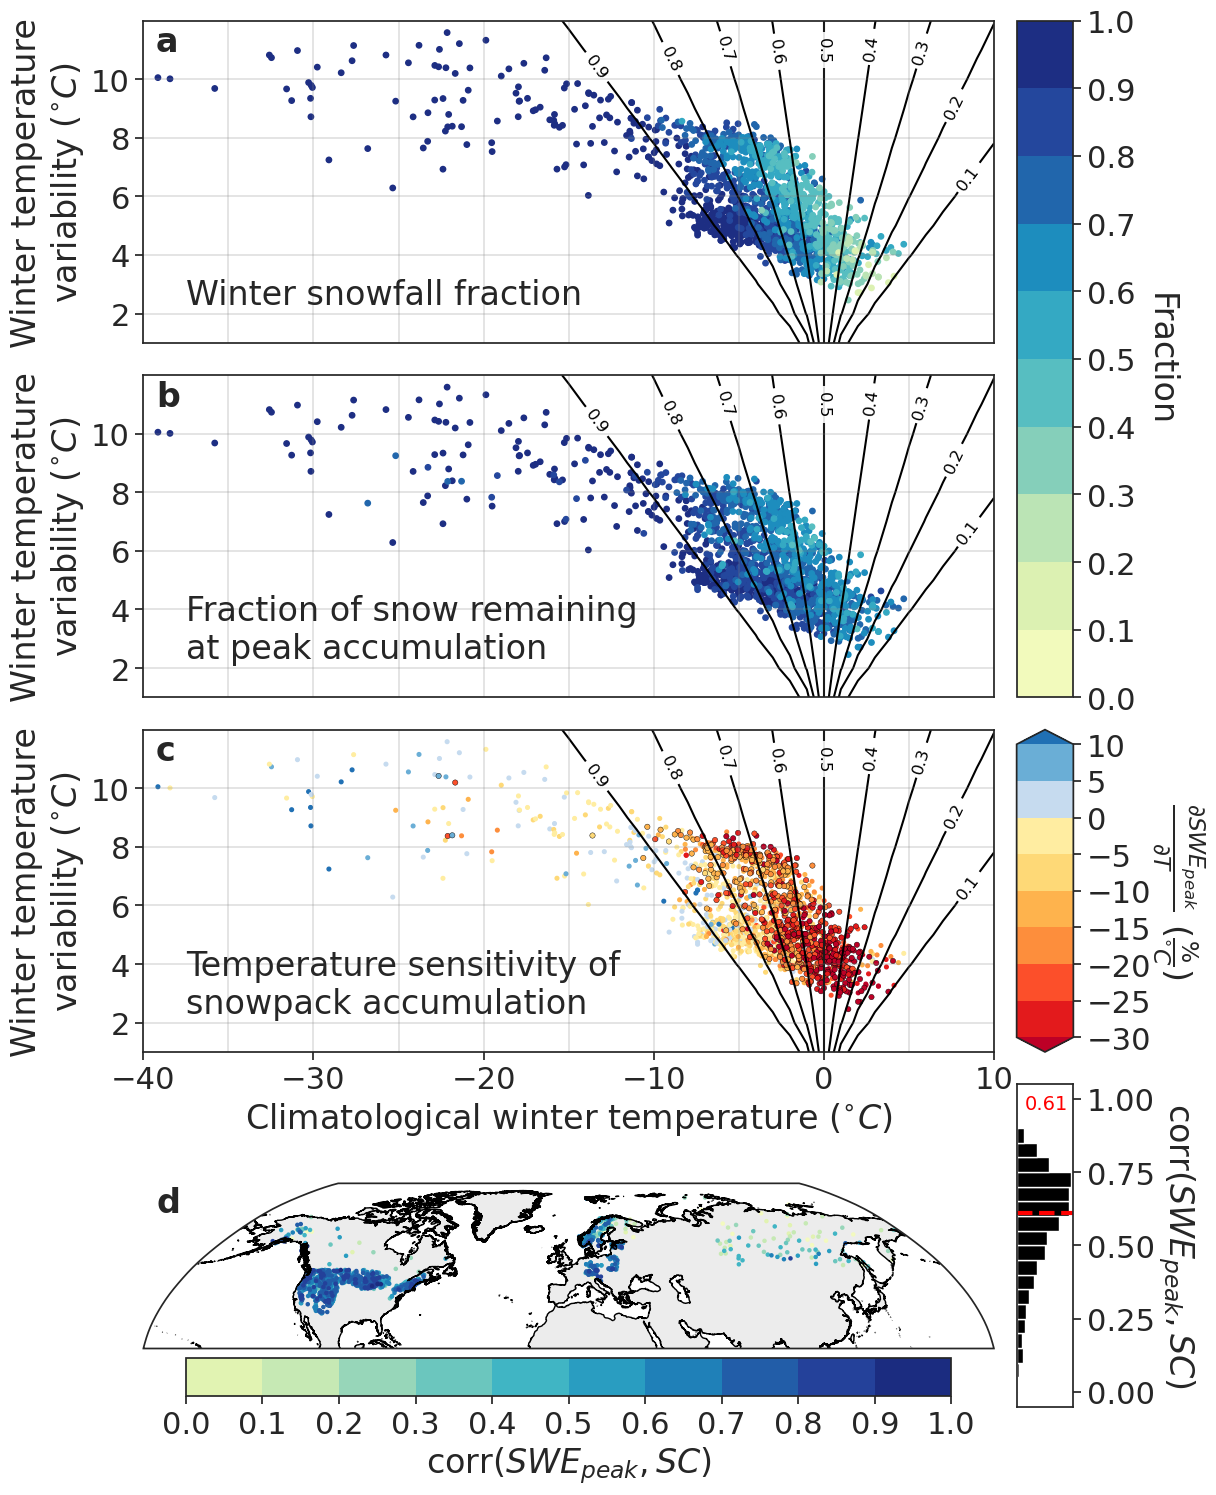

In [22]:
frac_cmap = mpl.colors.ListedColormap(sns.color_palette("YlGnBu",10))
frac_norm = plt.Normalize(vmin=0,vmax=1)

dsc_cols = np.concatenate([sns.color_palette("YlOrRd_r",7),sns.color_palette("Blues",3)])
dsc_cmap = mpl.colors.ListedColormap(dsc_cols[1:-1])
dsc_cmap.set_under(dsc_cols[0])
dsc_cmap.set_over(dsc_cols[-1])
dsc_norm = plt.Normalize(vmin=-30,vmax=10)

fig = plt.figure(figsize=(12,18))
gs = gridspec.GridSpec(nrows=4,ncols=2,width_ratios=[15,1],hspace=0.1,wspace=0.05,figure=fig)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0],)
ax3 = plt.subplot(gs[2,0],)
ax4 = plt.subplot(gs[3,0],projection=ccrs.Robinson())
ax5 = plt.subplot(gs[3,1])
# ax4 = plt.subplot(gs[0,1])
# ax5 = plt.subplot(gs[1,1])
# ax6 = plt.subplot(gs[2,1])
cmap = mpl.colors.ListedColormap(sns.color_palette("YlGnBu",10))
norm = plt.Normalize(vmin=0,vmax=1)

insitu_df.sort_values("snow_frac",ascending=False).plot.scatter(x='tavg',y='tavg_std',c='snow_frac',s=15,cmap=frac_cmap,norm=frac_norm,colorbar=False,ax=ax1)
ax1.set_xticks([])
ax1.set_xlabel("")
ax1.text(0.05,0.1,'Winter snowfall fraction',ha='left',va='bottom',transform=ax1.transAxes)
insitu_df.sort_values("melt_frac",ascending=False).plot.scatter(x='tavg',y='tavg_std',c='melt_frac',s=15,cmap=frac_cmap,norm=frac_norm,colorbar=False,ax=ax2)
ax2.set_xticks([])
ax2.set_xlabel("")
ax2.text(0.05,0.1,'Fraction of snow remaining\nat peak accumulation',ha='left',va='bottom',transform=ax2.transAxes)

cax1 = plt.subplot(gs[:2,1])
sm = plt.cm.ScalarMappable(norm=frac_norm,cmap=frac_cmap)
sm.set_array([])
cbar = fig.colorbar(sm,cax=cax1,orientation='vertical',drawedges=False,ticks=np.linspace(0,1,11),pad=0.03,shrink=0.9)
cbar.ax.set_ylabel('Fraction',rotation=-90,labelpad=30)

insitu_df[insitu_df['dswe_dt_p']>0.01].plot.scatter(x='tavg',y='tavg_std',c='dswe_dt',cmap=dsc_cmap,norm=dsc_norm,s=7,colorbar=False,ax=ax3)
insitu_df[insitu_df['dswe_dt_p']<0.01].plot.scatter(x='tavg',y='tavg_std',c='dswe_dt',cmap=dsc_cmap,norm=dsc_norm,edgecolor='black',lw=0.3,s=15,colorbar=False,ax=ax3)
ax3.set_xlabel("Climatological winter temperature ($^{\circ}C$)")
ax3.text(0.05,0.1,'Temperature sensitivity of\nsnowpack accumulation',ha='left',va='bottom',transform=ax3.transAxes)

cax2 = plt.subplot(gs[2,1])
sm = plt.cm.ScalarMappable(norm=dsc_norm,cmap=dsc_cmap)
sm.set_array([])
cbar = fig.colorbar(sm,cax=cax2,orientation='vertical',drawedges=False,ticks=np.arange(-30,11,5),extend='both',pad=0.03,shrink=0.5)
cbar.ax.set_ylabel(r'$\frac{\partial SWE_{peak}}{\partial T}$'+r' ($\frac{\%}{^{\circ}C}$)',rotation=-90,labelpad=40)

labels = ['a','b','c',]
i=0
for ax in [ax1,ax2,ax3]:
    cs = ax.contour(cd.astype(float),levels=np.linspace(0.1,1,10),extent=[-40,10,1,12],colors='black',linestyle='--')
    ax.clabel(cs,cs.levels,manual=[(-12,11),(-8,11),(-6,11),(-2,11),(-1,11),(4,11),(5.5,11),(8,9),(10,6)][::-1],fontsize=12)
    ax.set_ylabel("Winter temperature\nvariability ($^{\circ}C$)")
    ax.text(0.015,0.985,labels[i],ha='left',va='top',fontweight='bold',fontsize=24,transform=ax.transAxes)
    ax.set_yticks(np.arange(2,11,2))
    ax.vlines(np.arange(-40,11,5),ymin=1,ymax=12,color='grey',lw=0.3)
    ax.hlines(np.arange(2,12,2),xmin=-40,xmax=10,color='grey',lw=0.3)

    i+=1

corr_levels = np.linspace(0,1,11)
corr_cols = sns.color_palette('YlGnBu',len(corr_levels))
corr_cmap = mpl.colors.ListedColormap(corr_cols[1:])
corr_cmap.set_under(corr_cols[0])
corr_norm = plt.Normalize(vmin=0,vmax=1)
sc_swe_corr.to_dataframe().sort_values("r").plot.scatter(ax=ax4,x='lon',y='lat',c='r',transform=ccrs.PlateCarree(),cmap=corr_cmap,norm=corr_norm,colorbar=False,s=5)
ax4.coastlines("10m")
ax4.set_extent([-180,180,20,90],ccrs.PlateCarree())
ax4.add_feature(cartopy.feature.LAND,color='grey',alpha=0.15)
ax4.text(0.015,0.985,'d',ha='left',va='top',fontweight='bold',fontsize=24,transform=ax4.transAxes)
sm = plt.cm.ScalarMappable(norm=corr_norm,cmap=corr_cmap)
sm.set_array([])
cbar = fig.colorbar(sm,ax=ax4,orientation='horizontal',drawedges=False,ticks=corr_levels,pad=0.03,shrink=0.9)
cbar.ax.set_xlabel("corr($SWE_{peak},SC$)")
# ax5 = ax4.inset_axes([0.57,0.14,0.3,0.25])
ax5.hist(sc_swe_corr,bins=np.linspace(0,1,21),color='black',orientation='horizontal')
ax5.axhline(np.nanmedian(sc_swe_corr),color='red',linestyle='--',lw=3)
ax5.text(0.9,0.97,f'{np.round(np.nanmedian(sc_swe_corr),2)}',ha='right',va='top',color='red',fontsize=14,transform=ax5.transAxes)
ax5.yaxis.tick_right()
ax5.yaxis.set_label_position("right")
ax5.set_ylabel("corr($SWE_{peak},SC$)",rotation=-90,labelpad=30)
ax5.set_xticks([])

plt.savefig(os.path.join(project_dir,'reports','figures','r1','main','png','swe_sc.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'reports','figures','r1','main','pdf','swe_sc.pdf'),bbox_inches='tight',dpi=350)
    